# Radiative losses analysis with `ModeSolver`

`ModeSolver` can be used to simulate small radiative losses, without the need for a full FDTD simulation. Since these losses are often very small (on the order of $10^{-5}$ dB/cm), careful tuning of the parameters is necessary to ensure good convergence.

In this notebook, we will benchmark the required parameters to accurately calculate the imaginary part of the effective index for two types of losses: substrate leakage and bend losses.

For more information about the `ModeSolver` plugin, refer to this [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/ModeSolver/).

## Substrate leakage losses

In this example, we will simulate radiative losses into the substrate for a strip waveguide fabricated in SOI, where the SiO₂ layer is thin enough to allow losses into the Si layer.

We will compare our results with the ones obtained in the paper of `P. Bienstman, S. Selleri, L. Rosa, H. P. Uranus, W. C. L. Hopman, R. Costa, A. Melloni, L. C. Andreani, J. P. Hugonin, P. Lalanne, D. Pinto, S. S. A. Obayya, M. Dems, and K. Panajotov, "Modelling leaky photonic wires: A mode solver comparison", Optical and Quantum Electronics 38:731–759, (2006).` [DOI: 10.1007/s11082-006-9025-9](https://link.springer.com/article/10.1007/s11082-006-9025-9), where the authors benchmarked the radiative losses of the structure depicted above, using different numerical methods. 


<img src="img/RadiativeLossesModeSolver.png" width="450" alt="Schematic">

In [1]:
import tidy3d as td
import numpy as np
import matplotlib.pyplot as plt

from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver
from tidy3d.plugins.mode.web import run_batch

### Defining the simulation domain

We start defining a function for creating the `ModeSolver` object.

Since we are interested in losses, some attributes must be carefully defined.

1. The default boundary condition (BC) for the `ModeSolver` object is PEC. To study losses, we need to define a PML layer. This requires adding a tuple to the `num_pml` argument of the `ModeSpec` object, specifying the number of PML layers in each plane dimension.

   Note that the PML is added **inside** the simulation plane, so it is necessary to ensure that the simulation plane is large enough to prevent the PML from being too close to the structures. A good way to check this is by calling the `ModeSolver.plot()` method.

2. To study low losses, we set the `precision` argument to `double`, so the results will have more than six significant digits.

In [9]:
# defining the function for creating the ModeSolver object


def mode_solver_substrate_loss(
    resolution, npml, delta_override=None, size=(3, 4.3), num_modes=3, target_neff=2.41
):
    # waveguide structure
    wg = td.Structure(
        geometry=td.Box(size=(td.inf, 0.5, 0.22)),
        medium=td.Medium(permittivity=3.5**2),
    )

    # SiO2 layer
    box = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-td.inf, -td.inf, -100), rmax=(td.inf, td.inf, -0.11)
        ),
        medium=td.Medium(permittivity=1.45**2),
    )

    # Si substrate
    substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-td.inf, -td.inf, -100), rmax=(td.inf, td.inf, -1.11)
        ),
        medium=td.Medium(permittivity=3.5**2),
    )

    # mesh override region
    if delta_override:
        mesh_override = [
            td.MeshOverrideStructure(
                geometry=td.Box(center=(0, 0, 0), size=(0, 1.5, 1)),
                dl=(delta_override,) * 3,
            )
        ]
    else:
        mesh_override = []

    grid_spec = td.GridSpec.auto(
        min_steps_per_wvl=resolution, wavelength=1.55, override_structures=mesh_override
    )

    sim = td.Simulation(
        size=(4, size[0], size[1]),
        grid_spec=grid_spec,
        structures=[wg, box, substrate],
        run_time=1e-12,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        symmetry=(0, -1, 0),
    )

    mode_spec = td.ModeSpec(
        num_modes=num_modes,
        target_neff=target_neff,
        num_pml=(npml, npml),
        precision="double",
    )

    mode_solver = ModeSolver(
        simulation=sim,
        plane=td.Box.from_bounds(
            rmin=(0, -size[0] / 2, -((size[1] - 0.3) / 2 + 0.3)),
            rmax=(0, size[0] / 2, 2 + (size[1] - 0.3) / 2),
        ),
        mode_spec=mode_spec,
        freqs=[td.C_0 / 1.55],
    )
    return mode_solver

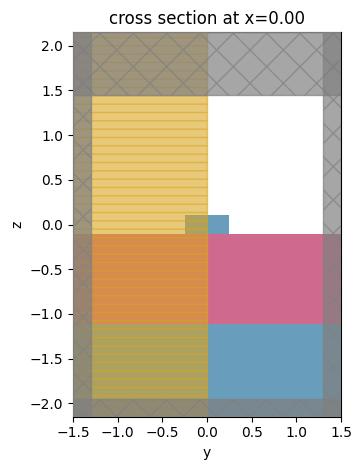

In [3]:
# visualizing the mode solver
mode_solver = mode_solver_substrate_loss(
    resolution=20,
    npml=9,
    delta_override=None,
)

mode_solver.plot()

plt.show()

Next, we run the mode solver to analyze the modes:

In [4]:
# run the mode solver
mode_data = run_mode_solver(mode_solver)

09:44:52 -03 Mode solver created with                                           
             task_id='fdve-dae1405f-031d-40d7-899a-a5d45ea619a9',               
             solver_id='mo-5bfee099-0443-4b82-a56d-c6a59b1c1746'.

Output()

Output()

09:44:56 -03 Mode solver status: success

Output()

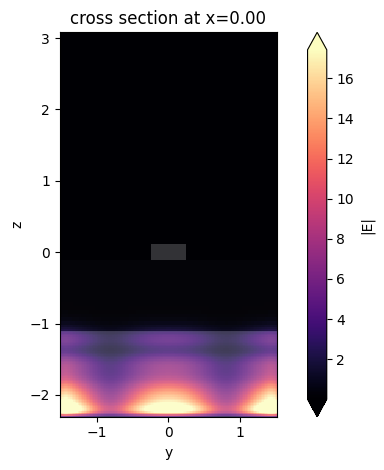

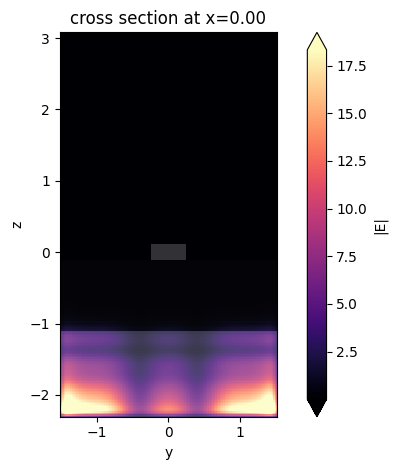

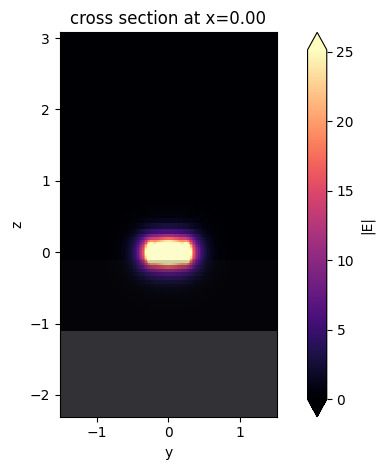

In [5]:
# plot the fields
for i in range(mode_solver.mode_spec.num_modes):
    mode_solver.plot_field("E", "abs", mode_index=i)

plt.show()

As one can note, the use of PMLs can lead to non-physical solutions. In this particular case, the physical mode is only the third one. Hence, when dealing with lossy structures, where PMLs are needed, it is important to carefully analyze the fields to exclude the non-physical ones. One way to achieve this is by looking at the effective index, which is approximately 2.4 for the real mode. Hence, we can just look at the mode closest to this value:

In [6]:
mode_data.to_dataframe()

wavelength     n eff         k eff   loss (dB/cm)  \
f            mode_index                                                      
1.934145e+14 0                 1.55  2.818499  3.787846e-01  133368.971246   
             1                 1.55  2.732204  4.492293e-01  158172.351666   
             2                 1.55  2.405265  3.473466e-08       0.012230   

                         TE (Ey) fraction  wg TE fraction  wg TM fraction  \
f            mode_index                                                     
1.934145e+14 0                    1.00000        0.969206        0.648322   
             1                    1.00000        0.897111        0.669513   
             2                    0.97956        0.726840        0.814311   

                         mode area  
f            mode_index             
1.934145e+14 0            1.405865  
             1            1.245057  
             2            0.185759

In most cases, the effective index is not known beforehand. To automatically filter the correct mode, we will create an auxiliary function that will compares the field energy around a given radius at the center of the simulation plane with the fields outside it, and return `True` if the field energy inside is higher than the energy outside, and `False` otherwise. Also, we will define a function to iterate through the modes and return the first valid mode.

In [2]:
# function to decide if a mode is a valid solution
def isMode(mode_data, mode_index, radius=1, freq_index=0):
    E = abs((mode_data.Ex**2 + mode_data.Ey**2 + mode_data.Ez**2))[
        0, :, :, freq_index, mode_index
    ]
    center = (
        E.y.min() + (E.y.max() - E.y.min()) / 2,
        E.z.min() + (E.z.max() - E.z.min()) / 2,
    )

    bmInside = (abs(E.y) < (center[0] + radius)) & (abs(E.z) < (center[1] + radius))

    if E.values[bmInside].sum() > E.values[~bmInside].sum():
        return True
    else:
        return False


# function to find the first valid mode
def findMode(mode_data, radius=1):
    for i in range(mode_data.Ex.shape[-1]):
        if isMode(mode_data, i, radius) == True:
            return i
    return None

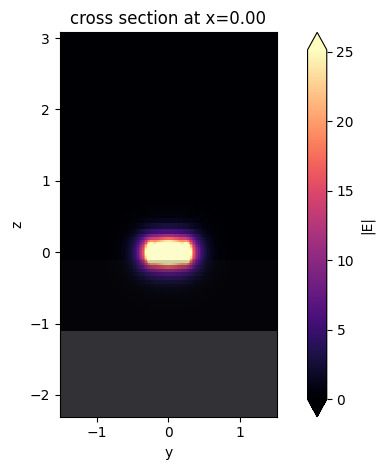

In [8]:
# testing
idx = findMode(mode_data)
mode_solver.plot_field("E", "abs", mode_index=idx)
plt.show()

### Convergence tests

First, we will analyze the convergence of the effective index as a function of the plane size:

In [9]:
sizes = np.arange(1, 4.5, 0.5)

# create a list with the mode solver objects
mode_solvers = []
for s in sizes:
    mode_solver = mode_solver_substrate_loss(
        resolution=30,
        npml=9,
        delta_override=None,
        size=(s, s + 1.3),
    )
    mode_solvers.append(mode_solver)

# run in batch
batch_data = run_batch(
    mode_solvers=mode_solvers,
    task_name="substrate_leakage_size",
    folder_name="radiative_losses",
    results_files=[f"size_{size:.2f}.hdf5" for size in sizes],
)

09:45:08 -03 Running a batch of 7 mode solvers.                                 
             

Output()

09:45:27 -03 A batch of `ModeSolver` tasks completed successfully!

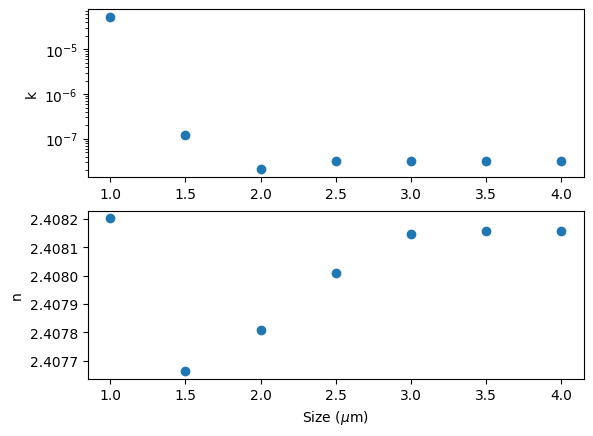

In [10]:
# analyzing the results
Real = []
Imag = []

for i, mode_data in enumerate(batch_data):
    idx = findMode(mode_data)

    Real.append(
        float(mode_data.n_complex.sel(f=mode_solver.freqs[0], mode_index=idx).real)
    )
    Imag.append(
        float(mode_data.n_complex.sel(f=mode_solver.freqs[0], mode_index=idx).imag)
    )

fig, ax = plt.subplots(2, 1)
ax[0].plot(sizes, Imag, "o")
ax[0].set_ylabel("k")
ax[0].set_yscale("log")

ax[1].plot(sizes, Real, "o")
ax[1].set_ylabel("n")
ax[1].set_xlabel("Size ($\mu$m)")

plt.show()

It is possible to note that the simulation size makes little difference in the results for the real part of the effective index. However, to achieve precise results for the imaginary part, it is important to fine-tune the mode plane size.

Next, we will run a sweep varying the resolution, analyze the behavior of both the real and imaginary parts of the effective index, and compare the results with the most precise values reported in the reference paper.

In [11]:
resolution = [20, 60, 100, 140, 180, 200]
mode_solvers = []
for r in resolution:
    mode_solver = mode_solver_substrate_loss(
        resolution=r, npml=9, delta_override=None, size=(4, 5.3)
    )
    mode_solvers.append(mode_solver)

batch_data = run_batch(
    mode_solvers=mode_solvers,
    task_name="substrate_leakage_resolution",
    folder_name="radiative_losses",
    results_files=[f"resolution_{r:.2f}.hdf5" for r in resolution],
)

09:45:28 -03 Running a batch of 6 mode solvers.                                 
             

Output()

09:48:43 -03 A batch of `ModeSolver` tasks completed successfully!

It is notable that the results converge well toward the most precise values reported in the paper, although high resolution is needed for optimal accuracy.

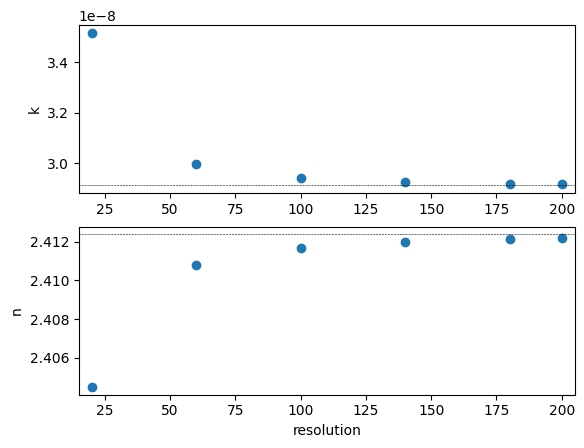

In [12]:
Real = []
Imag = []


for i, mode_data in enumerate(batch_data):
    idx = findMode(mode_data)

    Real.append(
        float(mode_data.n_complex.sel(f=mode_solver.freqs[0], mode_index=idx).real)
    )
    Imag.append(
        float(mode_data.n_complex.sel(f=mode_solver.freqs[0], mode_index=idx).imag)
    )


fig, ax = plt.subplots(2, 1)
ax[0].plot(resolution, Imag, "o")
ax[0].hlines(2.913e-8, xmin=0, xmax=300, color="black", ls="--", lw=0.4)
ax[0].set_xlim(15, 205)
ax[0].set_ylabel("k")


ax[1].plot(resolution, Real, "o")
ax[1].hlines(2.41237, xmin=0, xmax=300, color="black", ls="--", lw=0.4)
ax[1].set_xlim(15, 205)
ax[1].set_ylabel("n")
ax[1].set_xlabel("resolution")

plt.show()

### Real part

One can note that the imaginary part of the effective index converges better than the real part in the plot shown above. It is worth mentioning that, for calculating the real part, placing a mesh override region around the waveguide improves the convergence speed without requiring a high mesh density across the entire simulation plane. However, in this case, the imaginary part may exhibit greater error.

In [13]:
grid_step = [0.1, 0.05, 0.01, 0.005, 0.002]
mode_solvers = []
for dl in grid_step:
    mode_solver = mode_solver_substrate_loss(
        resolution=20,
        npml=9,
        delta_override=dl,
        size=(4, 5.3),
    )
    mode_solvers.append(mode_solver)

batch_data = run_batch(
    mode_solvers=mode_solvers,
    task_name="substrate_leakage_dl",
    folder_name="radiative_losses",
    results_files=[f"dl_{dl:.2f}.hdf5" for dl in grid_step],
)

09:48:46 -03 Running a batch of 5 mode solvers.                                 
             

Output()

09:49:33 -03 A batch of `ModeSolver` tasks completed successfully!

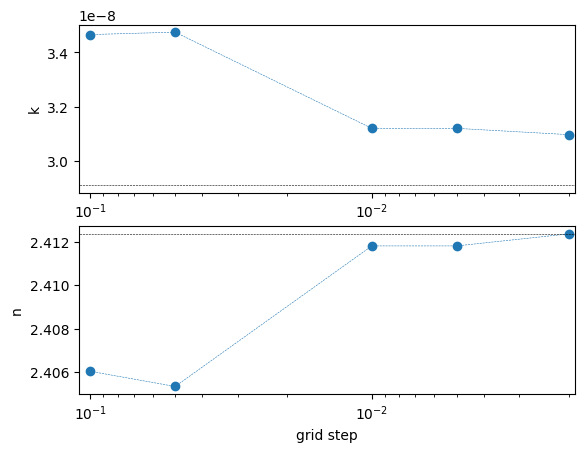

In [14]:
real = []
imag = []

for i, mode_data in enumerate(batch_data):
    idx = findMode(mode_data)

    real.append(
        float(mode_data.n_complex.sel(f=mode_solver.freqs[0], mode_index=idx).real)
    )
    imag.append(
        float(mode_data.n_complex.sel(f=mode_solver.freqs[0], mode_index=idx).imag)
    )

fig, ax = plt.subplots(2, 1)
ax[0].plot(grid_step, Imag, "--o", lw=0.4)
ax[0].hlines(2.913e-8, xmin=0, xmax=300, color="black", ls="--", lw=0.4)
ax[0].set_xlim(0.11, 0.0019)
ax[0].set_xscale("log")
ax[0].set_ylabel("k")

ax[1].plot(grid_step, real, "--o", lw=0.4)
ax[1].hlines(2.41237, xmin=0, xmax=300, color="black", ls="--", lw=0.4)
ax[1].set_xlim(0.11, 0.0019)
ax[1].set_xscale("log")
ax[1].set_ylabel("n")
ax[1].set_xlabel("grid step")

plt.show()

## Bent SiN waveguide

Next, we will study radiative losses in a bent SiN waveguide.

In [3]:
# function to define the mode solver
def mode_solver_SiN_wvg(
    resolution,
    npml,
    delta_override=None,
    size=(20,15),
    nun_modes=10,
    target_neff=1.547,
    bend_radius=None,
    bend_axis=1,
    symmetry=(0, 0, 1),
):
    siN = td.Medium(permittivity=2**2)
    sio2 = td.Medium(permittivity=1.444**2)

    structures = [td.Structure(geometry=td.Box(size=(100, 0.6, 0.4)), medium=siN)]

    mode_spec = td.ModeSpec(
        num_modes=nun_modes,
        target_neff=target_neff,
        precision="double",
        bend_radius=bend_radius,
        bend_axis=bend_axis,
        num_pml=(npml, npml),
    )

    if delta_override:
        mesh_override = [
            td.MeshOverrideStructure(
                geometry=td.Box(center=(0, 0, 0), size=(0, 2 * 0.6, 2 * 0.22)),
                dl=(delta_override,) * 3,
            )
        ]
    else:
        mesh_override = []

    grid_spec = td.GridSpec.auto(
        min_steps_per_wvl=resolution, wavelength=1.55, override_structures=mesh_override
    )

    sim = td.Simulation(
        size=(10, size[0], size[1]),
        center=(0, 0, 0),
        grid_spec=grid_spec,
        structures=structures,
        sources=[],
        monitors=[],
        run_time=1e-12,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        symmetry=symmetry,
        medium=sio2,
    )

    plane = td.Box(center=(0, 0, 0), size=(0, size[0], size[1]))

    mode_solver = ModeSolver(
        simulation=sim, plane=plane, mode_spec=mode_spec, freqs=[td.C_0 / 1.55]
    )

    return mode_solver

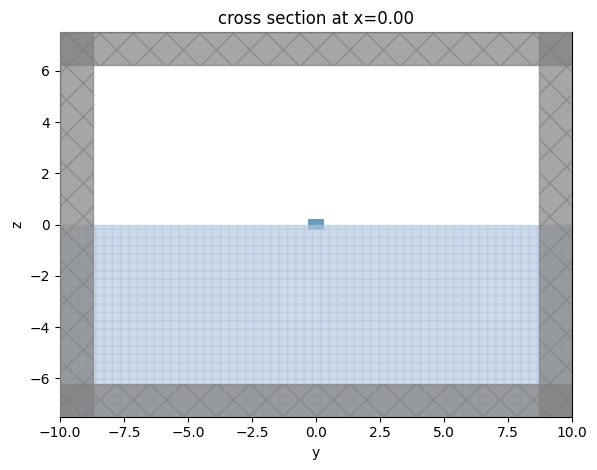

In [4]:
# visualizing the mode solver
ms = mode_solver_SiN_wvg(10,12)
ms.plot()
plt.show()

### Plane Size

Due to the relatively low index contrast between core and clad, the evanescent fields are long, so it is necessary to carefully define the simulation size. Evanescent fields in the [PML can lead to artificial gain](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PML.html) and yield inaccurate results. This issue becomes more significant for larger bend radii, as the losses are smaller. 

To study this issue, we will test the plane size for several bend radii and choose the minimum value that yields positive results, meaning that the PML error contribution becomes smaller than the physical losses.

In [5]:
radius = np.linspace(20,130,10)
sizes = []
loss = []


for r in radius:
    l = -1
    size = 3
    while l < 0:
        mode_solver = mode_solver_SiN_wvg(
            resolution=10,
            npml=12,
            nun_modes=5,
            bend_radius=r,
            bend_axis=1,
            size=(size,size),
        )

        mode_data = run_mode_solver(mode_solver,verbose=False)

        idx = findMode(mode_data, 0.4)

        l = mode_data.to_dataframe().iloc[idx]["loss (dB/cm)"]
        size += 1

        
    loss.append(loss)
    sizes.append(size)

As we can see, the plane size needed for physical results increases approximately linearly with the bend radius.

For simplicity, we conducted the tests with the same size for the y and z dimensions. However, since the bend is in the y dimension, the size in the z dimension can be smaller.

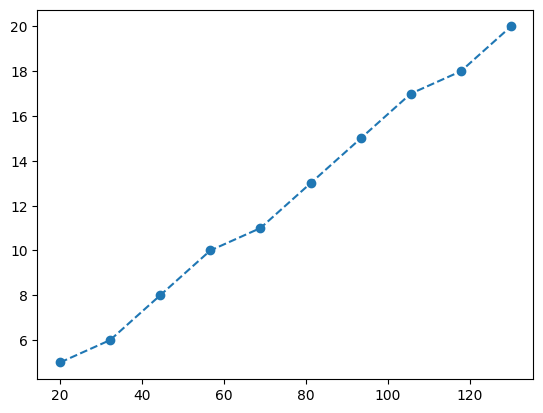

In [6]:
fig,ax = plt.subplots()
ax.plot(radius,sizes,'--o')

After defining an appropriate plane size that can handle large bend radii, we will analyze the losses as a function of the bend radius using two different resolution parameters: 10 and 50.

In [15]:
# creating the mode solver objects and running in batch

radius = np.linspace(20, 130, 10)

mode_solvers = []
for r in radius:
    mode_solver = mode_solver_SiN_wvg(
        resolution=10,
        npml=12,
        nun_modes=5,
        bend_radius=r,
        bend_axis=1,
        size=(20,15),
    )

    mode_solvers.append(mode_solver)

batch_data = run_batch(
    mode_solvers=mode_solvers,
    task_name="SiN_wvg",
    folder_name="radiative_losses",
    results_files=[f"radius_res20_{r:.2f}.hdf5" for r in radius],
)

09:26:57 -03 Running a batch of 10 mode solvers.                                
             

Output()

09:28:47 -03 A batch of `ModeSolver` tasks completed successfully!

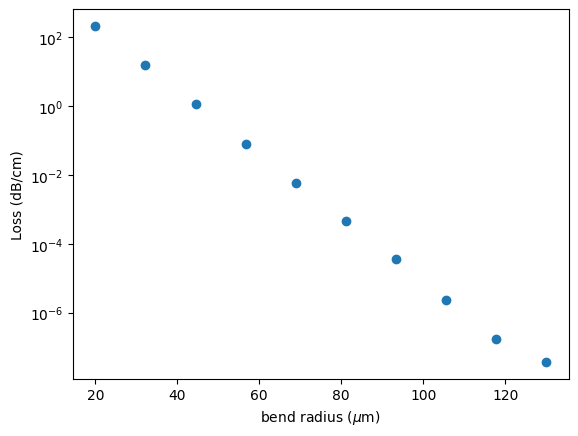

In [16]:
loss_10 = []

for i, mode_data in enumerate(batch_data):
    idx = findMode(mode_data, 0.4)
    loss_10.append(mode_data.to_dataframe().iloc[idx]["loss (dB/cm)"])

fig, ax = plt.subplots()
ax.plot(radius, loss_10, "o")
ax.set_yscale("log")
ax.set_xlabel("bend radius ($\mu$m)")
ax.set_ylabel("Loss (dB/cm)")
plt.show()

As we can note, the losses decrease exponentially as a function of the bend radius.

Next, we will perform the same analysis using a finer resolution.

In [20]:
radius = np.linspace(20, 130, 10)

loss_50 = []

for r in radius:
    mode_solver = mode_solver_SiN_wvg(
        resolution=50,
        npml=12,
        nun_modes=5,
        bend_radius=r,
        bend_axis=1,
        size=(20,15),
    )

    mode_data = run_mode_solver(mode_solver, verbose=False)
    idx = findMode(mode_data, 0.4)
    loss_50.append(mode_data.to_dataframe().iloc[idx]["loss (dB/cm)"])

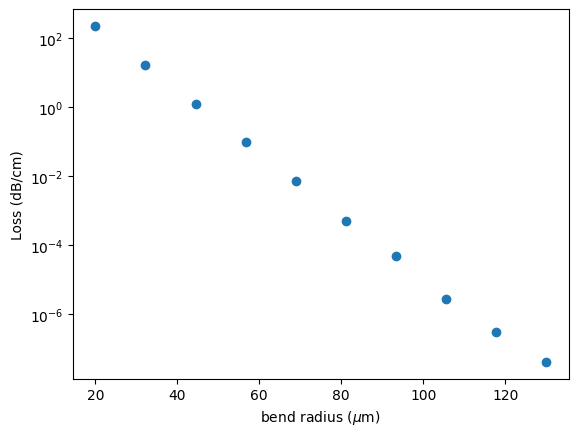

In [21]:
fig, ax = plt.subplots()
ax.plot(radius, loss_50, "o")
ax.set_yscale("log")
ax.set_xlabel("bend radius ($\mu$m)")
ax.set_ylabel("Loss (dB/cm)")
plt.show()

Next, we will analyze the deviation between the two resolutions:

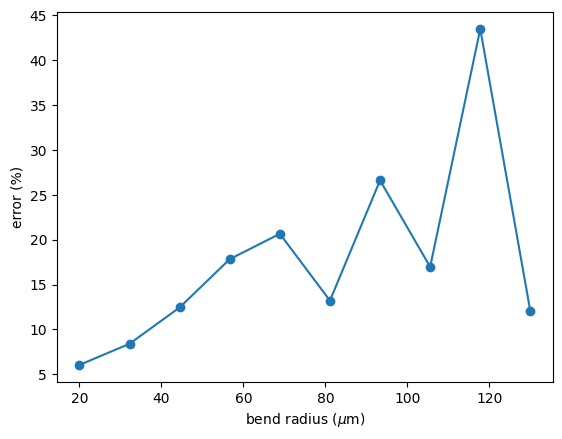

In [22]:
fig, ax = plt.subplots()
ax.plot(
    radius,
    100 * np.sqrt((np.array(loss_50) - np.array(loss_10)) ** 2) / np.array(loss_50),
    "-o",
)

ax.set_xlabel("bend radius ($\mu$m)")
ax.set_ylabel("error (%)")

plt.show()

It can be noted that the error for the lower resolution can reach up to 43% for low losses.

To analyze the convergence, we will plot the loss as a function of resolution for a fixed bend radius of 120 μm.

In [23]:
Loss = []

resolution = np.linspace(20, 100, 6)
mode_solvers = []
for r in resolution:
    mode_solver = mode_solver_SiN_wvg(
        bend_radius=120,
        npml=12,
        bend_axis=1,
        resolution=r,
        nun_modes=10,
        size=(20,15),
    )

    mode_data = run_mode_solver(mode_solver, verbose=False)

    idx = findMode(mode_data, 0.4)

    Loss.append(mode_data.to_dataframe().iloc[idx]["loss (dB/cm)"])

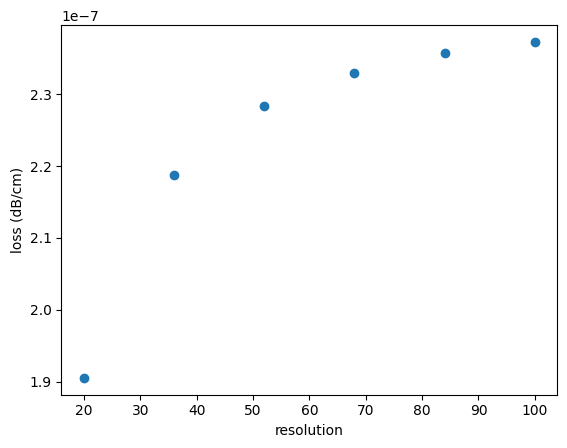

In [24]:
fig, ax = plt.subplots()
ax.plot(resolution, Loss, "o")
ax.set_xlabel("resolution")
ax.set_ylabel("loss (dB/cm)")
plt.show()

As we can see, the loss values converge for high resolutions.

In conclusion, the general behavior of the losses can be captured with a reasonable resolution. However, if a very precise result is desired, a very high resolution is required.

## Losses in a bent optical fiber

Finally, we will estimate the bend losses in an optical fiber.

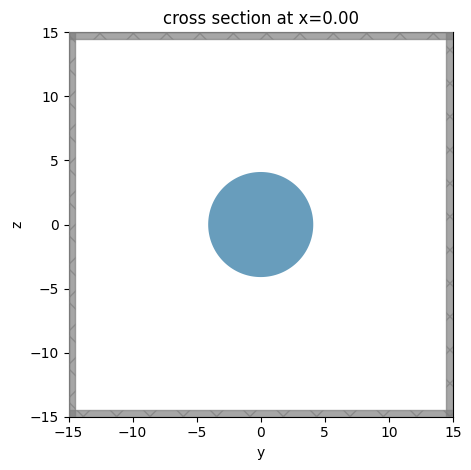

In [3]:
def mode_solver_fiber(
    resolution,
    npml,
    delta_override=None,
    size=(30, 30),
    num_modes=10,
    bend_radius=None,
    symmetry=(0, 0, 0),
    target_neff=1.41,
    fiber_radius=4.1,
    coreIndex=1.45213,
    cladIndex=1.44692,
):
    fiberDiameter = 2 * fiber_radius

    fiber = td.Cylinder(
        axis=0, radius=fiberDiameter / 2, center=(0, 0, 0), length=td.inf
    )

    structures = [
        td.Structure(geometry=fiber, medium=td.Medium(permittivity=coreIndex**2))
    ]

    mode_spec = td.ModeSpec(
        num_modes=num_modes,
        target_neff=target_neff,
        precision="double",
        bend_radius=bend_radius,
        bend_axis=1,
        num_pml=(npml, npml),
    )

    if delta_override:
        mesh_override = [
            td.MeshOverrideStructure(
                geometry=td.Box(
                    center=(0, 0, 0), size=(1, 3 * fiber_radius, 3 * fiber_radius)
                ),
                dl=(delta_override,) * 3,
            )
        ]
    else:
        mesh_override = []

    grid_spec = td.GridSpec.auto(
        min_steps_per_wvl=resolution, wavelength=1.55, override_structures=mesh_override
    )

    sim = td.Simulation(
        size=(10, size[0], size[1]),
        center=(0, 0, 0),
        grid_spec=grid_spec,
        structures=structures,
        sources=[],
        monitors=[],
        run_time=1e-12,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.Absorber(num_layers=20)),
        symmetry=symmetry,
        medium=td.Medium(permittivity=cladIndex**2),
    )

    plane = td.Box(center=(0, 0, 0), size=(0, size[0], size[1]))

    mode_solver = ModeSolver(
        simulation=sim, plane=plane, mode_spec=mode_spec, freqs=[td.C_0 / 1.55]
    )

    return mode_solver


ms = mode_solver_fiber(20, 10, delta_override=0.01)
ms.plot()
plt.show()

Due to the low index contrast, a fiber is more sensitive to losses; hence, larger bend radii can be analyzed.

Again, we need to define a proper plane size. To do so, we will benchmark the losses for a 30 mm bend radius as a function of the plane size. As observed, physical values are obtained only for sizes up to 100 μm.

In [4]:
Loss = []
sizes = [40, 60, 80, 100, 120]
for size in sizes:
    mode_solver = mode_solver_fiber(
        bend_radius=30000,
        npml=12,
        resolution=10,
        size=(size, size),
        target_neff=1.449,
        symmetry=(0, 0, 1),
        delta_override=0.05,
        num_modes=10,
    )

    mode_data = run_mode_solver(mode_solver, verbose=False)
    idx = findMode(mode_data, 3)
    Loss.append(mode_data.to_dataframe().iloc[idx]["loss (dB/cm)"])

In [5]:
# print the results
print("Size: \t loss (dB/cm)")
for i, s in enumerate(sizes):
    print("%s \t %s" % (s, Loss[i]))

Size: 	 loss (dB/cm)
40 	 -0.0019541640400151487
60 	 -2.9236682322432187e-05
80 	 -7.110892900303177e-07
100 	 1.9607458191609075e-07
120 	 1.7595460603248643e-07


Finally, we will analyze the imaginary part of the effective index as a function of the bend radius and compare the results with the analytical model developed by Dietrich Marcuse published in the work "Curvature loss formula for optical fibers" [DOI: https://doi.org/10.1364/JOSA.66.000216](https://doi.org/10.1364/JOSA.66.000216).

In this model, the loss coefficient $\alpha$ is given by:

$2\alpha = \frac{\sqrt(\pi)k^2e^{-(2/3)(\frac{\gamma^3}{\beta_g^2})R}}{e_\nu \gamma^{3/2}V^2\sqrt{R}K_{\nu-1}(\gamma a)K_{\nu+1}(\gamma a)}$

where: 

$k = \sqrt{(n_1 2\pi/\lambda)^2 -\beta_g^2}$

$\gamma = \sqrt{(\beta_g^2-(n_2 2\pi/\lambda)^2)}$

$e_\nu = 1$ for $\nu = 0$ else 2

$V^2 = (a 2\pi/\lambda)^2(n_1^2-n_2^2)$

and $n_1$ is the core index, $n_2$ is the clad index, $a$ is the core radius, $R$ is the bend radius, $\beta_g$ is the constant of a straight waveguide, and $K_\nu$ is the modified Hankel function.

In [6]:
Loss = []
Keff = []

radius = [5000, 10000, 15000, 20000, 25000, 30000]
for r in radius:
    mode_solver = mode_solver_fiber(
        bend_radius=r,
        npml=12,
        resolution=10,
        size=(100, 100),
        target_neff=1.449,
        symmetry=(0, 0, 1),
        delta_override=0.05,
        num_modes=5,
    )

    mode_data = run_mode_solver(mode_solver, verbose=False)
    idx = findMode(mode_data, 4)

    Loss.append(mode_data.to_dataframe().iloc[idx]["loss (dB/cm)"])
    Keff.append(mode_data.to_dataframe().iloc[idx]["k eff"])

As we can see, the simulated results, with proper simulation size, match very well the analytical results up to $k_{eff}$ at the order of $10^{-12}$

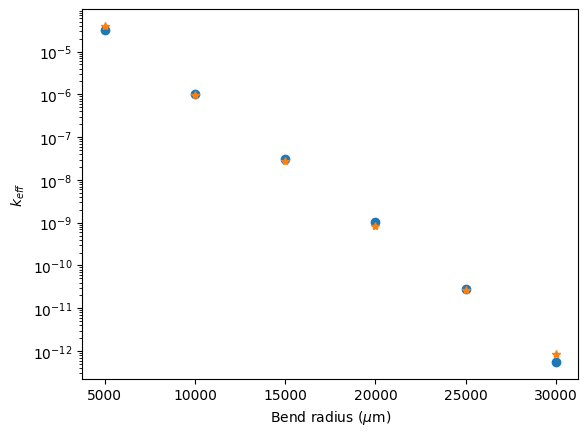

In [7]:
# function for calculation alpha
def alpha(R, a=4.1, nmode=1.449156, n1=1.45213, n2=1.44692, lda0=1.55, mode=0):
    beta = 2 * np.pi * nmode / lda0
    ev = 2 if mode == 0 else 1
    k0 = np.pi * 2 / lda0
    gamma = np.sqrt(beta**2 - (n2**2) * (k0**2))
    k = np.sqrt((n1**2) * k0**2 - beta**2)
    Vsquare = (k0**2) * (a**2) * (n1**2 - n2**2)

    from scipy.special import kv

    up = np.sqrt(np.pi) * (k**2) * np.exp(-(2 / 3) * ((gamma**3) / (beta**2)) * R)
    down = (
        ev
        * (gamma ** (3 / 2))
        * Vsquare
        * np.sqrt(R)
        * kv(mode - 1, gamma * a)
        * kv(mode + 1, gamma * a)
    )

    return np.real((1 / 2) * (up / down))


fig, ax = plt.subplots()

ax.plot(radius, Keff, "o", label="Simulated")
ax.plot(
    radius,
    [alpha(r) * 1.55 / (4 * np.pi) for r in radius],
    "*",
    label="Analytical model",
)
ax.set_yscale("log")
ax.set_xlabel("Bend radius ($\mu$m)")
ax.set_ylabel("$k_{eff}$")

plt.show()